In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
import keras
from tensorflow.python.framework import ops
from utils import *
import json
from datetime import datetime

## Replicating CNN from Noda Paper

https://opg.optica.org/oe/fulltext.cfm?uri=oe-26-25-32704&id=402684

Their model is very simple:
### Layers:
    2D convolutional layer, kernel size (3x5), stride (1x2), 50 filters
    Dense layer with 500 units, ReLU activation
    Dropout layer
    Dense layer with 50 units, ReLU activation
    Dense layer with 1 units, ReLU activaiton

In [2]:
data_path = r"Z:\srobison\Simulation\COMSOL\DeepLearning_vNew\DataManager\testData.mat"
mechFreq, optFreq, mechQ, optQ, paramsMat = load_data(data_path)

paramsShape = np.shape(paramsMat)[:-1]
num_examples = np.shape(paramsMat)[-1]
optQ_linearized = np.log(optQ)

paramsMat_transposed = tf.transpose(paramsMat, perm = [3, 0, 1, 2])
print("shape of paramsMat_transposed: \t", np.shape(paramsMat_transposed))

print("shape of optQ: \t", np.shape(optQ))

print("number of training examples: \t", num_examples)

Loading data from:  Z:\srobison\Simulation\COMSOL\DeepLearning_vNew\DataManager\testData.mat 

shape of paramsMat_transposed: 	 (911, 11, 18, 3)
shape of optQ: 	 (911, 1)
number of training examples: 	 911


Text(0, 0.5, 'occurences in data set')

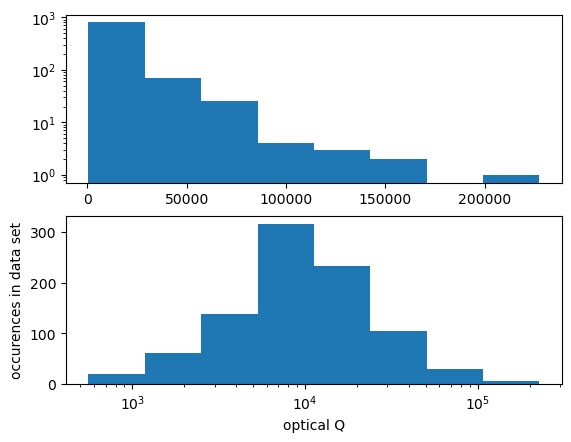

In [3]:
# looking at the data a bit:

x = optQ
# histogram on linear scale
plt.subplot(211)
hist, bins, _ = plt.hist(x, bins=8)
plt.yscale('log')

# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.subplot(212)
plt.hist(x, bins=logbins)
plt.xscale('log')
plt.xlabel("optical Q")
plt.ylabel('occurences in data set')

Split the data into train and test sets using tensorflow. Because optical Q is generally sampled logrithmically, to train with a linear activation in the last layer we should take the log of the optical Q data before giving it to the model.

In [4]:
dataset = tf.data.Dataset.from_tensor_slices((paramsMat_transposed, optQ_linearized))

# Shuffle and split the dataset
train_size = int(0.8 * num_examples)
train_dataset = dataset.shuffle(buffer_size=num_examples).take(train_size)
test_dataset = dataset.skip(train_size)

# Example of batching the datasets
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

Define the model

In [5]:
# define the model using the functional API structure rather than teh sequential structure in order to make it more flexible in the future.

def Noda_model(input_shape):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> FLATTEN -> DENSE 200 -> RELU -> DROPOUT -> DENSE 50 -> RELU -> DENSE 1

    Arguments:
    input_img -- input dataset, of shape (input_shape)
    kernel_size -- list of kernel sizes for each Conv2D step
    pool_size -- list of pool sizes for each MaxPool2D step

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """

    input_img = tf.keras.Input(shape=input_shape)

    Z1 = tfl.Conv2D(filters = 50, kernel_size = (5, 3), strides = (2, 1), padding = 'same')(input_img)
    A1 = tfl.ReLU()(Z1)
    F = tfl.Flatten()(A1)

    A2 = tfl.Dense(200, activation = 'relu')(F)
    D = tfl.Dropout(rate = 0.01)(A2)
    A3 = tfl.Dense(50, activation = 'relu')(D)

    output = tfl.Dense(1)(A3)
    
    model = tf.keras.Model(inputs=input_img, outputs=output)
    return model

In [6]:
conv_model = Noda_model(paramsShape)
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
conv_model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics =['mse'])

conv_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 11, 18, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 6, 18, 50)           │           2,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 6, 18, 50)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 200)                 │       1,080,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │          10,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,092,601 (4.17 MB)

 Trainable params: 1,092,601 (4.17 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 24.0981 - mse: 24.0981 - val_loss: 2.5524 - val_mse: 2.5524
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7782 - mse: 1.7782 - val_loss: 1.0587 - val_mse: 1.0587
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2003 - mse: 1.2003 - val_loss: 1.0312 - val_mse: 1.0312
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9692 - mse: 0.9692 - val_loss: 0.9860 - val_mse: 0.9860
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1432 - mse: 1.1432 - val_loss: 1.2672 - val_mse: 1.2672
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2727 - mse: 1.2727 - val_loss: 0.9341 - val_mse: 0.9341
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0539 - mse: 1.0539 - val_loss: 0.9227 - val_mse: 0.9227
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9733 - mse: 0.9733 - val_loss: 0.9260 - val_mse: 0.9260
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

In [8]:
conv_model.evaluate(test_dataset)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0961 - mse: 0.0961


[0.10108187794685364, 0.10108187794685364]

Index(['loss', 'mse', 'val_loss', 'val_mse'], dtype='object')


C:\Users\Linus\AppData\Local\Temp\ipykernel_9908\747123822.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
C:\Users\Linus\AppData\Local\Temp\ipykernel_9908\747123822.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mse.rename(columns={'mse':'train','val_mse':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss')]

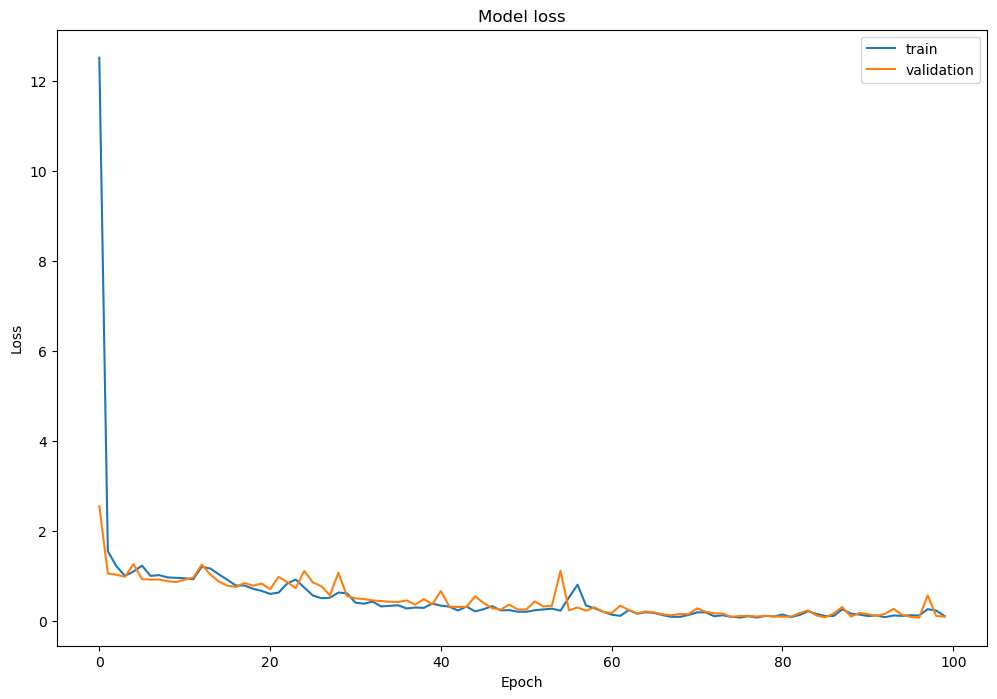

In [9]:
df_loss_acc = pd.DataFrame(history.history)
print(df_loss_acc.columns)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_mse= df_loss_acc[['mse','val_mse']]
df_mse.rename(columns={'mse':'train','val_mse':'validation'},inplace=True)

df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
# df_mse.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='MSE')

With a trained model in hand it might be nice to see individual examples of how good it is at predicting...

In [10]:
train_numbers = np.arange(10)
for train_number in train_numbers:
    test_iterator = iter(test_dataset)
    
    # Get a single batch (you can also use next(test_iterator) for just one item in the batch)
    batch_X, batch_Y = next(test_iterator)
    
    # Extract a single input and label pair from the batch
    # For example, take the first item from the batch
    single_input = batch_X[train_number].numpy()  # Convert to NumPy array
    single_label = batch_Y[train_number].numpy()  # Convert to NumPy array
    
    single_input =  np.expand_dims(single_input, axis=0) 
    
    prediction = conv_model.predict(single_input)
    
    print("predicted Q = {}".format(np.exp(prediction)))
    print("true Q = {}".format(np.exp(single_label)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
predicted Q = [[24314.852]]
true Q = [18979.77548522]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
predicted Q = [[63316.402]]
true Q = [49243.36569778]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
predicted Q = [[8248.472]]
true Q = [7866.39080575]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
predicted Q = [[13279.231]]
true Q = [9167.0738224]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted Q = [[10683.165]]
true Q = [8730.27137618]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
predicted Q = [[7762.6714]]
true Q = [5796.2399872]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
predicted Q = [[6934.9683]]
true Q = [5382.76852792]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted Q = [[1808.4054]]
true Q = [1183.77318019]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted Q = [[30585.123]]
true Q = [21780.798181]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
predicted Q = [[1525.5009]]
true Q = [1138.57869454]


Noda model is fine but not amazing.  I think adding dropout is a nice feature.